## Environment Preparation

* Load the library code from the local package directory
* Load the API key and secret in the .env file

In [1]:
# Quick hack to load local library code
import os

os.chdir(os.path.join(os.getcwd(), ".."))

# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

True

## ValidMind Python Library Introduction

In [3]:
import pandas as pd
import xgboost as xgb

from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

%matplotlib inline

## Initializing the ValidMind Library

After creating an account with ValidMind, we can find the project's API key and secret in the settings page of the ValidMind dashboard:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/settings.png" width="600" height="300" />

The library credentials can be configured in two ways:

- By setting the `VM_API_KEY` and `VM_API_SECRET` environment variables or
- By passing `api_key` and `api_secret` arguments to the `init` function like this:

```python
vm.init(
    api_key='<your-api-key>',
    api_secret='<your-api-secret>',
    project="cl2r3k1ri000009jweny7ba1g"
)
```

The `project` argument is mandatory since it allows the library to associate all data collected with a specific account project.

In [4]:
import validmind as vm

# Use api_host="https://api.dev.vm.validmind.ai/api/v1/tracking" if you want to connect to the dev environment
vm.init(project="cl1jyv16o000809lg98gi9tie")

True

### Using a demo dataset

For this simple demonstration, we will use the following bank customer churn dataset from Kaggle: https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/data.

We will train a sample model and demonstrate the following library functionalities:

- Logging information about a dataset
- Running data quality tests on a dataset
- Logging information about a model
- Logging training metrics for a model
- Running model evaluation tests

Before we logging any data on a new project, the ValidMind dashboard will let users know that they can automatically populate the different documentation sections by integrating the ValidMind into a model development environment:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/empty-data-description.png" width="600" height="300">

#### Logging general project metadata with `log_metadata`

The ValidMind library provides a function to log free-form metadata for a project. A list of preconfigured `content_id` can be used to select where in the dashboard documentation we want this metadata to be displayed. As an example, if a model developer wants to populate the `Model Overview` section for a project, they can use `model_overview` as the `content_id`:

```python
vm.log_metadata("model_overview", text="Testing")
```

The `text` argument accepts Markdown formatted text as we'll see in the cell below. The documentation used for this model has been taken from the [Kaggle dataset](https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/data).

In [5]:
model_overview = """
Testing writing metadata from the framework
The ValidMind library provides a function to log free-form metadata for a project. A list of preconfigured `content_id` can be used to select where in the dashboard documentation we want this metadata to be displayed. As an example, if a model developer wants to populate the `Model Overview` section for a project, they can use `model_overview` as the `content_id`

We aim to accomplish the following for this study:

- Identify and visualize which factors contribute to customer churn
- Build a prediction model that will perform the following:
  - Classify if a customer is going to churn or not
  - Preferably and based on model performance, choose a model that will attach a probability
  to the churn to make it easier for customer service to target low hanging fruits in their
  efforts to prevent churn
"""

vm.log_metadata(content_id="model_overview", text=model_overview)

True

The dashboard should now display the `Model Overview` section with the text we have provided from the library:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/model-overview.png" width="600" height="300">

### Running a data quality test plan

We will now run the default data quality test plan that will collect the
following metadata from a dataset:

- Field types and descriptions
- Descriptive statistics
- Data distribution histograms
- Feature correlations

and will run a collection of data quality tests such as:

- Class imbalance
- Duplicates
- High cardinality
- Missing values
- Skewness

ValidMind evaluates if the data quality metrics are within expected ranges. These thresholds or ranges can be further configured by model validators.

### Load our demo dataset

Before running the test plan, we must first load the dataset into a Pandas DataFrame and initialize
a ValidMind dataset object:

In [6]:
df = pd.read_csv("notebooks/datasets/bank_customer_churn.csv")

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="Exited",
    class_labels={
        "0": "Did not exit",
        "1": "Exited",
    }
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


#### Initialize and run the TabularDataQuality test plan

We can now initialize the `TabularDataQuality` test plan. The primary method of doing this is with the `run_test_plan` function from the `vm` module. This function takes in a test plan name (in this case `tabular_data_quality`) and a `dataset` keyword argument (the `vm_dataset` object we created earlier):

```python
vm.run_test_plan("tabular_data_quality", dataset=vm_dataset)
```

In [7]:
vm.run_test_plan("tabular_data_quality", dataset=vm_dataset)

### Finding all test plans available in the developer framework

We can find all the test plans available in the developer framework by calling the following functions:

- All test plans: `vm.test_plans.list_plans()`
- Describe a test plan: `vm.test_plans.describe_plan("tabular_dataset")`
- List all available tests: `vm.test_plans.list_tests()`

As an example, here's the outpout `list_plans()` and `list_tests()`:

In [8]:
vm.test_plans.list_plans()

ID,Name,Description
sklearn_classifier_metrics,SKLearnClassifierMetrics,Test plan for sklearn classifier metrics
sklearn_classifier_validation,SKLearnClassifierPerformance,Test plan for sklearn classifier models
sklearn_classifier,SKLearnClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets


In [9]:
vm.test_plans.list_tests()

Test Type,ID,Name,Description
Metric,dataset_correlations,DatasetCorrelations,Extracts the correlation matrix for a dataset. The following coefficients are calculated: - Pearson's R for numerical variables - Cramer's V for categorical variables - Correlation ratios for categorical-numerical variables
Metric,dataset_description,DatasetDescription,Collects a set of descriptive statistics for a dataset
Custom Test,dataset_metadata,DatasetMetadata,Custom class to collect a set of descriptive statistics for a dataset. This class will log dataset metadata via `log_dataset` instead of a metric. Dataset metadat is necessary to initialize dataset object that can be related to different metrics and test results
ThresholdTest,class_imbalance,ClassImbalanceTest,Test that the minority class does not represent more than a threshold of the total number of examples
ThresholdTest,duplicates,DuplicatesTest,Test that the number of duplicates is less than a threshold
ThresholdTest,cardinality,HighCardinalityTest,Test that the number of unique values in a column is less than a threshold
ThresholdTest,pearson_correlation,HighPearsonCorrelationTest,Test that the Pearson correlation between two columns is less than a threshold Inspired by: https://github.com/ydataai/pandas-profiling/blob/f8bad5dde27e3f87f11ac74fb8966c034bc22db8/src/pandas_profiling/model/correlations.py
ThresholdTest,missing,MissingValuesTest,Test that the number of missing values is less than a threshold
ThresholdTest,skewness,SkewnessTest,Test that the skewness of a column is less than a threshold
ThresholdTest,unique,UniqueRowsTest,Test that the number of unique rows is greater than a threshold


Once the `TabularDataset` test plan has finished running, we can view the results in the ValidMind dashboard:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/data-description.png" width="600" height="300">

### Preparing the dataset for training

Before we train a model, we need to run some common minimal feature selection and engineering steps on the dataset:

- Dropping irrelevant variables
- Encoding categorical variables

#### Dropping irrelevant variables

The following variables will be dropped from the dataset:

- `RowNumber`: it's a unique identifier to the record
- `CustomerId`: it's a unique identifier to the customer
- `Surname`: no predictive power for this variable
- `CreditScore`: we didn't observer any correlation between `CreditScore` and our target column `Exited`

In [10]:
df.drop(["RowNumber", "CustomerId", "Surname", "CreditScore"], axis=1, inplace=True)

#### Encoding categorical variables

We will apply one-hot or dummy encoding to the following variables:

- `Geography`: only 3 unique values found in the dataset
- `Gender`: convert from string to integer

In [11]:
genders = {"Male": 0, "Female": 1}
df.replace({"Gender": genders}, inplace=True)

In [12]:
df = pd.concat([df, pd.get_dummies(df["Geography"], prefix="Geography")], axis=1)
df.drop("Geography", axis=1, inplace=True)

We are now ready to train our model with the preprocessed dataset:

In [13]:
df.head()

,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


#### Dataset preparation

For training our model, we will **randomly** split the dataset in 3 parts:

- `training` split with 60% of the rows
- `validation` split with 20% of the rows
- `test` split with 20% of the rows

The `test` dataset will be our held out dataset for model evaluation.

In [14]:
train_df, test_df = train_test_split(df, test_size=0.20)

# This guarantees a 60/20/20 split
train_ds, val_ds = train_test_split(train_df, test_size=0.25)

# For training
x_train = train_ds.drop("Exited", axis=1)
y_train = train_ds.loc[:, "Exited"].astype(int)
x_val = val_ds.drop("Exited", axis=1)
y_val = val_ds.loc[:, "Exited"].astype(int)

# For testing
x_test = test_df.drop("Exited", axis=1)
y_test = test_df.loc[:, "Exited"].astype(int)

### Model training

We will train a simple XGBoost model and set its `eval_set` to `[(x_train, y_train), (x_val, y_val)]` in order to collect validation datasets metrics on every round. The ValidMind library supports collecting any type of "in training" metrics so model developers can provide additional context to model validators if necessary.

In [15]:
model = xgb.XGBClassifier(early_stopping_rounds=10)
model.set_params(
    eval_metric=["error", "logloss", "auc"],
)
model.fit(
    x_train,
    y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    verbose=False,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [16]:
y_pred = model.predict_proba(x_val)[:, -1]
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_val, predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.875


### Running a model evaluation test plan

We will now run a basic model evaluation test plan that is compatible with the model we have trained.
Since we have trained an XGBoost model with a sklearn-like API, we will use the `SKLearnClassifier` test plan. This test plan will collect model metadata and metrics, and run a variety of model evaluation tests, according to the modeling objective (binary classification for this example).

The following model metadata is collected:

- Model framework and architecture (e.g. XGBoost, Random Forest, Logistic Regression, etc.)
- Model task details (e.g. binary classification, regression, etc.)
- Model hyperparameters (e.g. number of trees, max depth, etc.)

The model metrics that are collected depend on the model type, use case, etc. For example, for a binary classification model, the following metrics could be collected (again, depending on configuration):

- AUC
- Error rate
- Logloss
- Feature importance

Similarly, different model evaluation tests are run depending on the model type, use case, etc. For example, for a binary classification model, the following tests could be executed:

- Simple training/test overfit test
- Training/test performance degradation
- Baseline test dataset performance test

#### Initialize VM model object and train/test datasets

In order to run our SKLearnClassifier test plan, we need to initialize ValidMind object instances for the trained model and the training and test datasets:

In [17]:
vm_model = vm.init_model(model)
vm_train_ds = vm.init_dataset(dataset=train_ds, type="generic", target_column="Exited")
vm_test_ds = vm.init_dataset(dataset=test_df, type="generic", target_column="Exited")

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


We can now run the `SKLearnClassifier` test plan:

Running SHAPGlobalImportance: shap:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 12/13 [00:00<00:00, 26.66it/s]ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



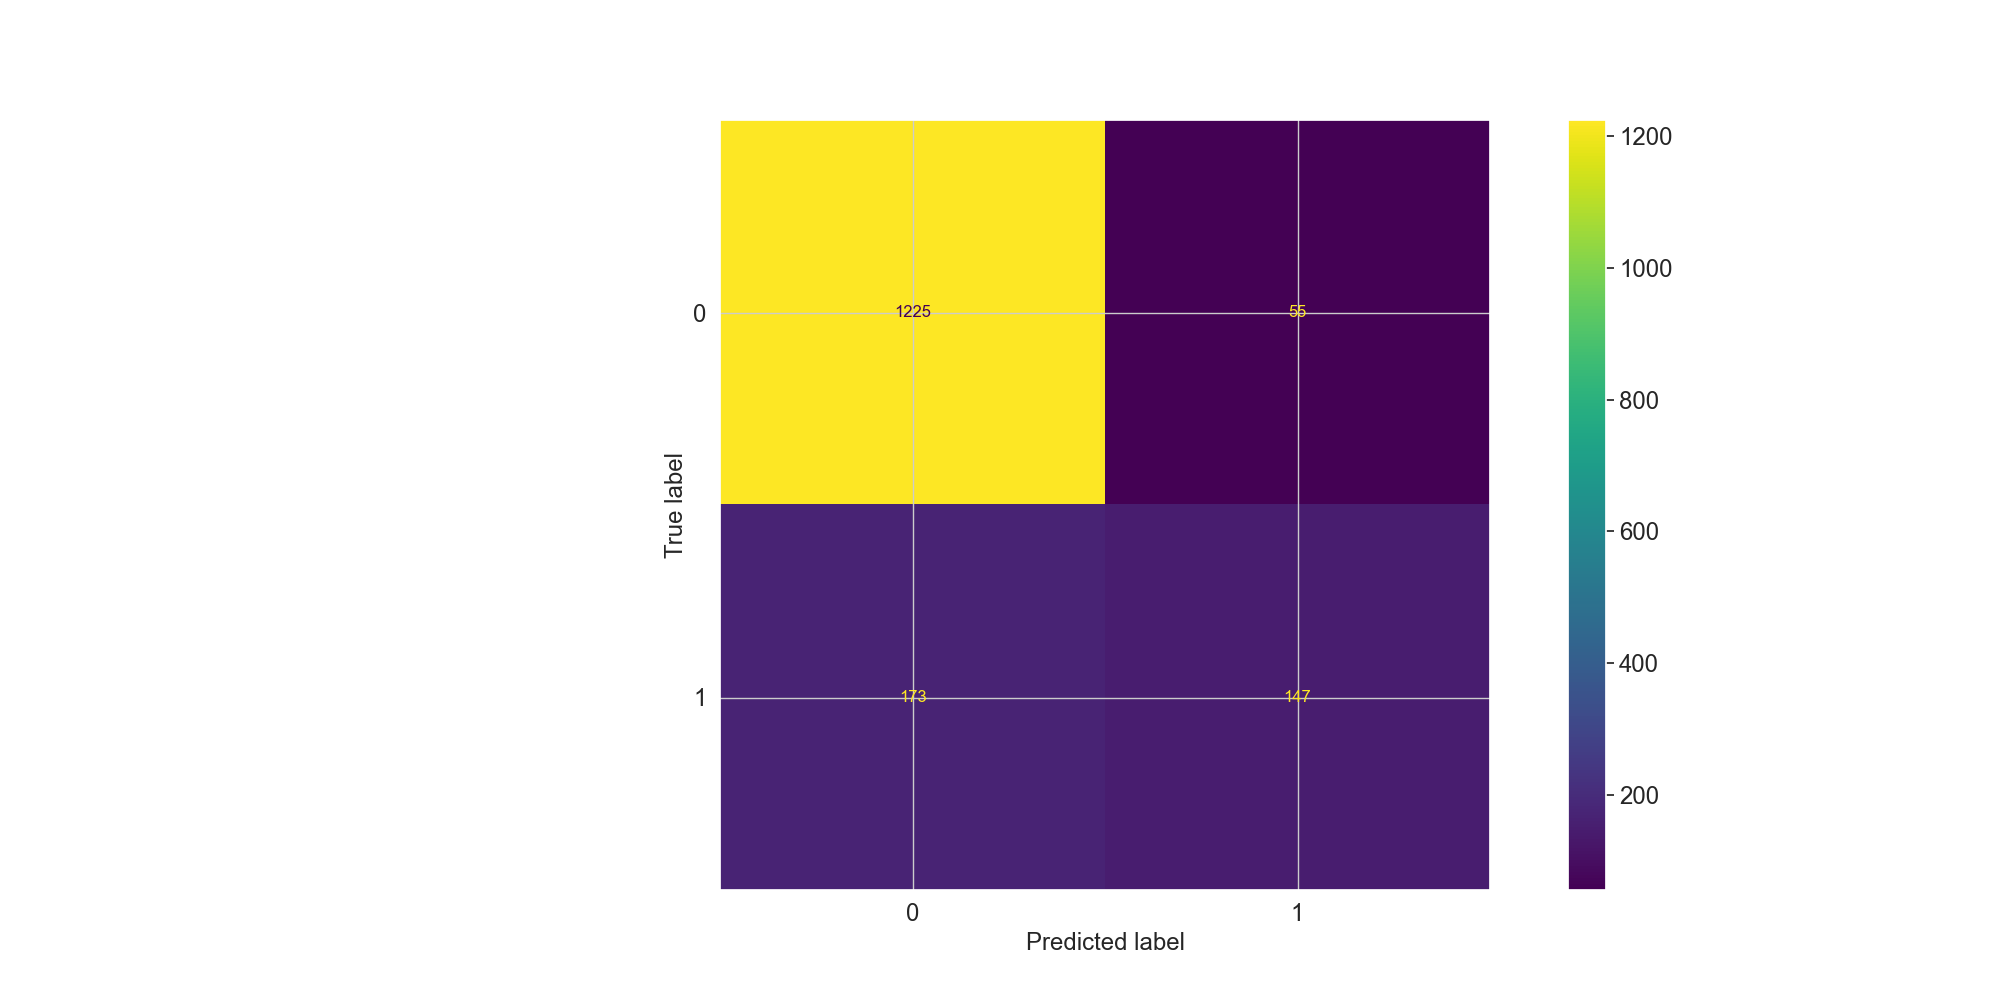
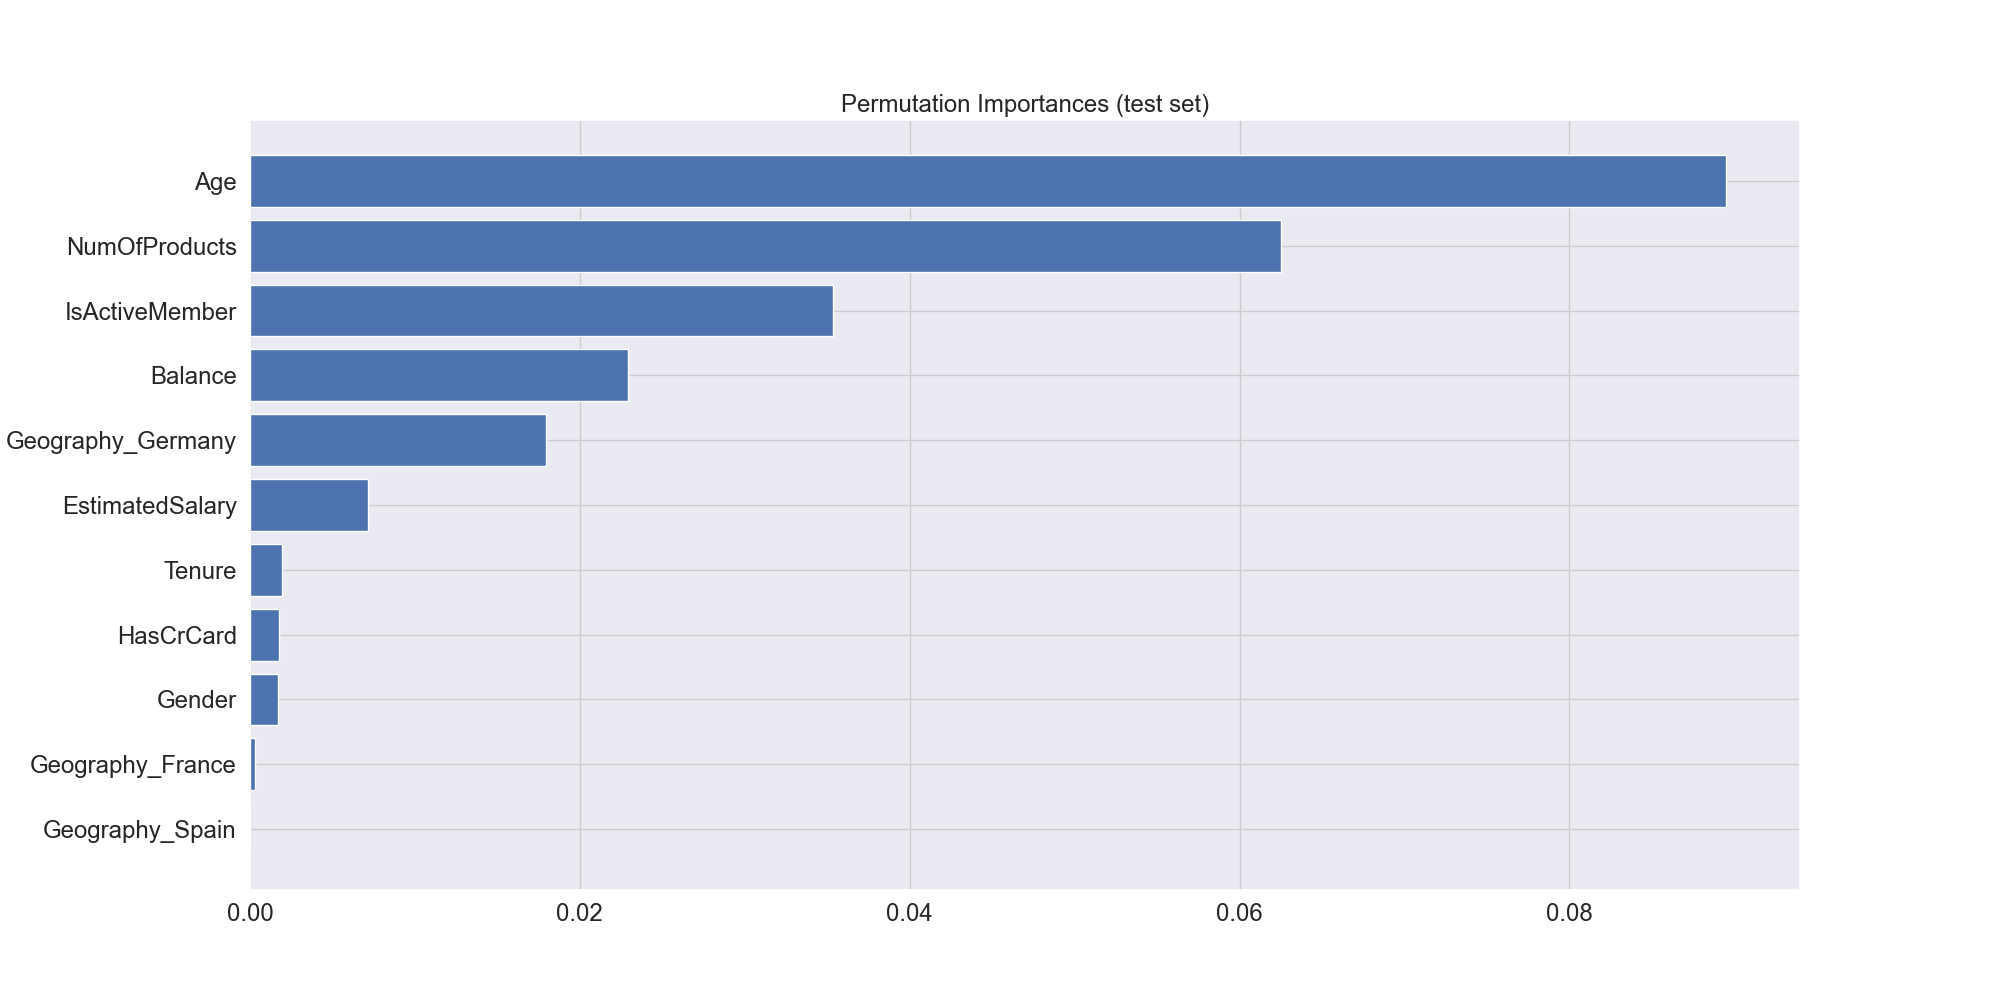
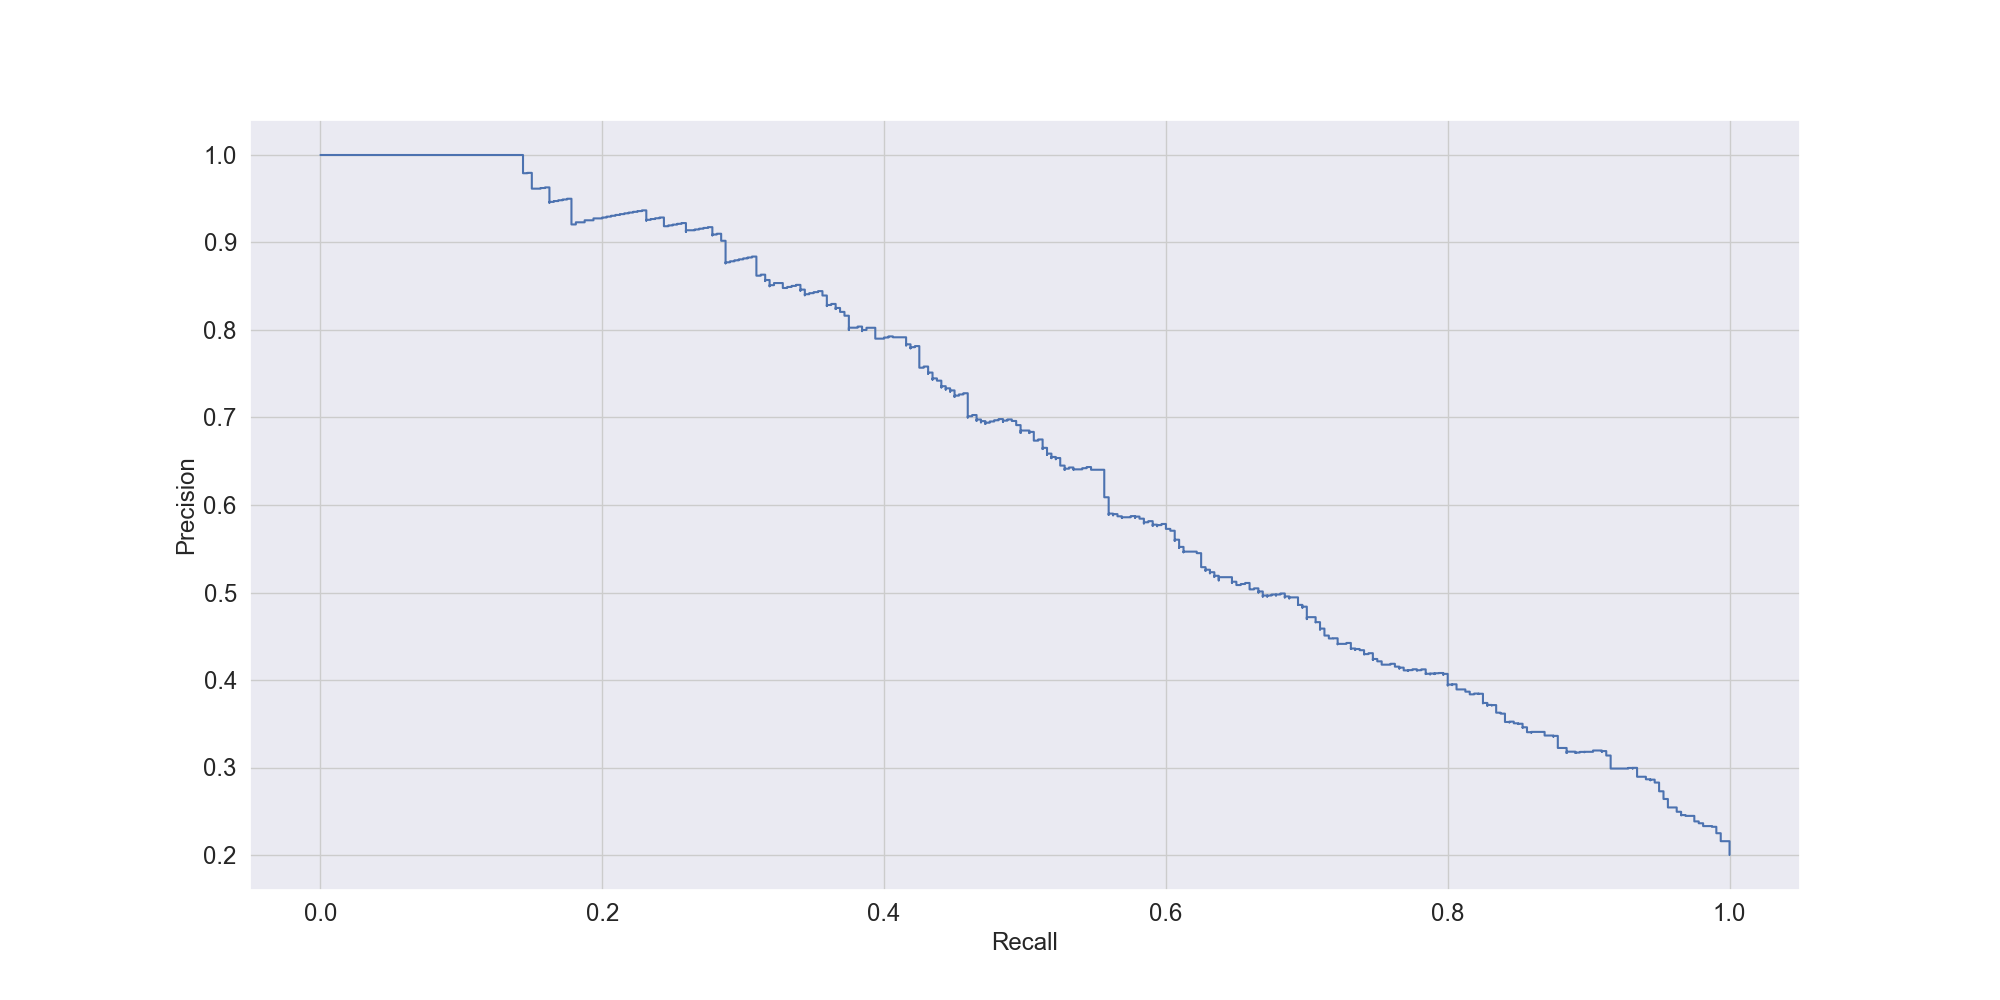
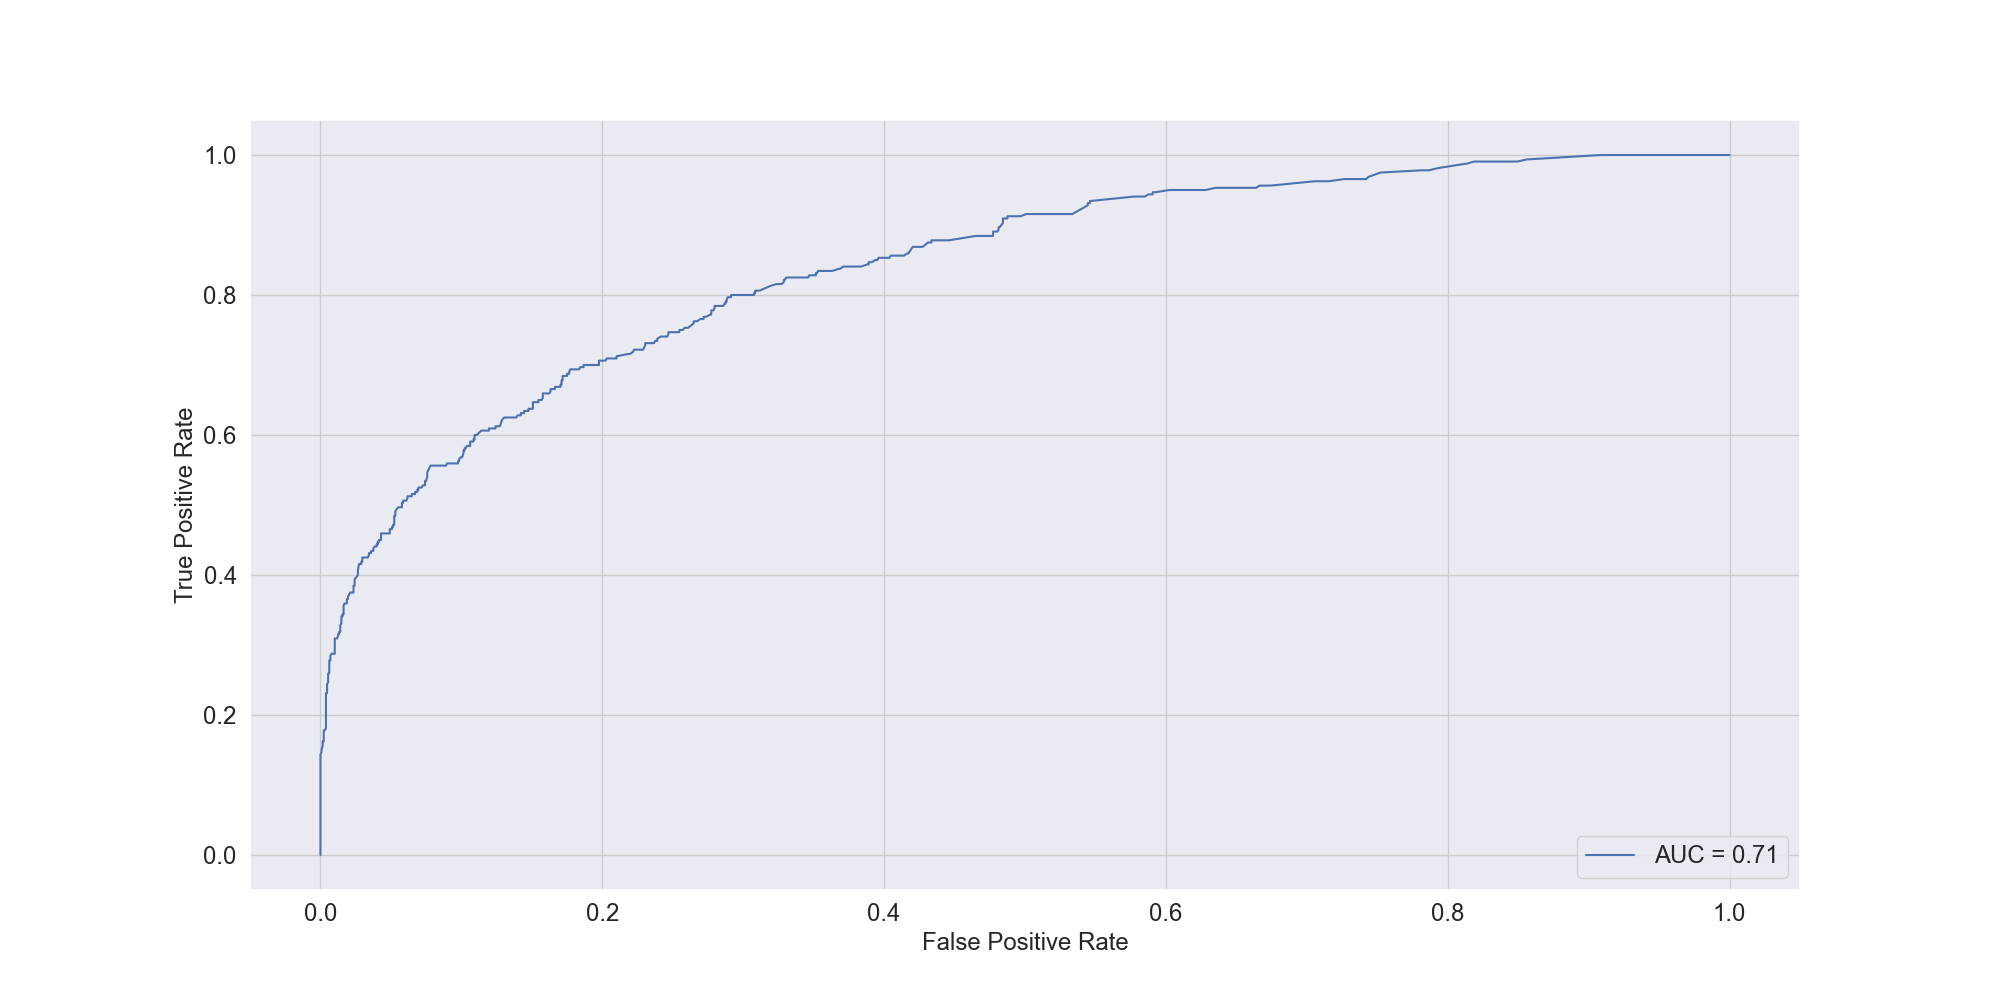
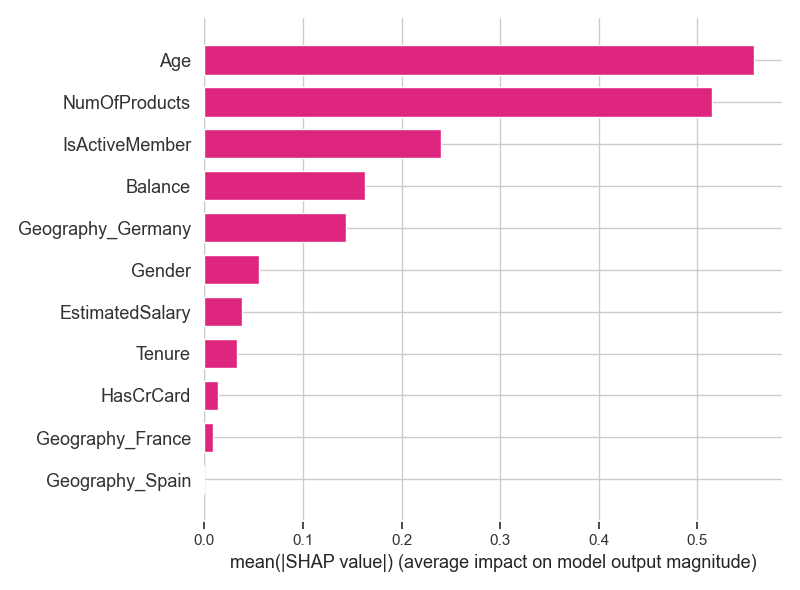
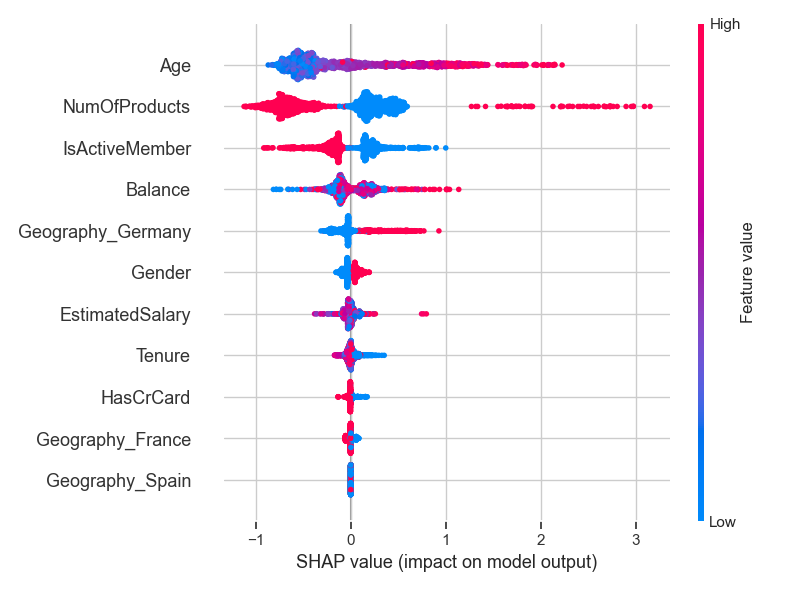

In [19]:
vm.run_test_plan("sklearn_classifier", model=vm_model, train_ds=vm_train_ds, test_ds=vm_test_ds)